In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cc = pd.read_csv('../input/credit_card_balance.csv')

In [3]:
cc.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [4]:
cc.isnull().sum() / len(cc)

SK_ID_PREV                    0.000000
SK_ID_CURR                    0.000000
MONTHS_BALANCE                0.000000
AMT_BALANCE                   0.000000
AMT_CREDIT_LIMIT_ACTUAL       0.000000
AMT_DRAWINGS_ATM_CURRENT      0.195249
AMT_DRAWINGS_CURRENT          0.000000
AMT_DRAWINGS_OTHER_CURRENT    0.195249
AMT_DRAWINGS_POS_CURRENT      0.195249
AMT_INST_MIN_REGULARITY       0.079482
AMT_PAYMENT_CURRENT           0.199981
AMT_PAYMENT_TOTAL_CURRENT     0.000000
AMT_RECEIVABLE_PRINCIPAL      0.000000
AMT_RECIVABLE                 0.000000
AMT_TOTAL_RECEIVABLE          0.000000
CNT_DRAWINGS_ATM_CURRENT      0.195249
CNT_DRAWINGS_CURRENT          0.000000
CNT_DRAWINGS_OTHER_CURRENT    0.195249
CNT_DRAWINGS_POS_CURRENT      0.195249
CNT_INSTALMENT_MATURE_CUM     0.079482
NAME_CONTRACT_STATUS          0.000000
SK_DPD                        0.000000
SK_DPD_DEF                    0.000000
dtype: float64

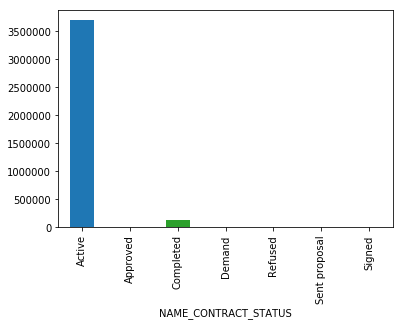

In [5]:
cc.groupby('NAME_CONTRACT_STATUS').size().plot(kind='bar')

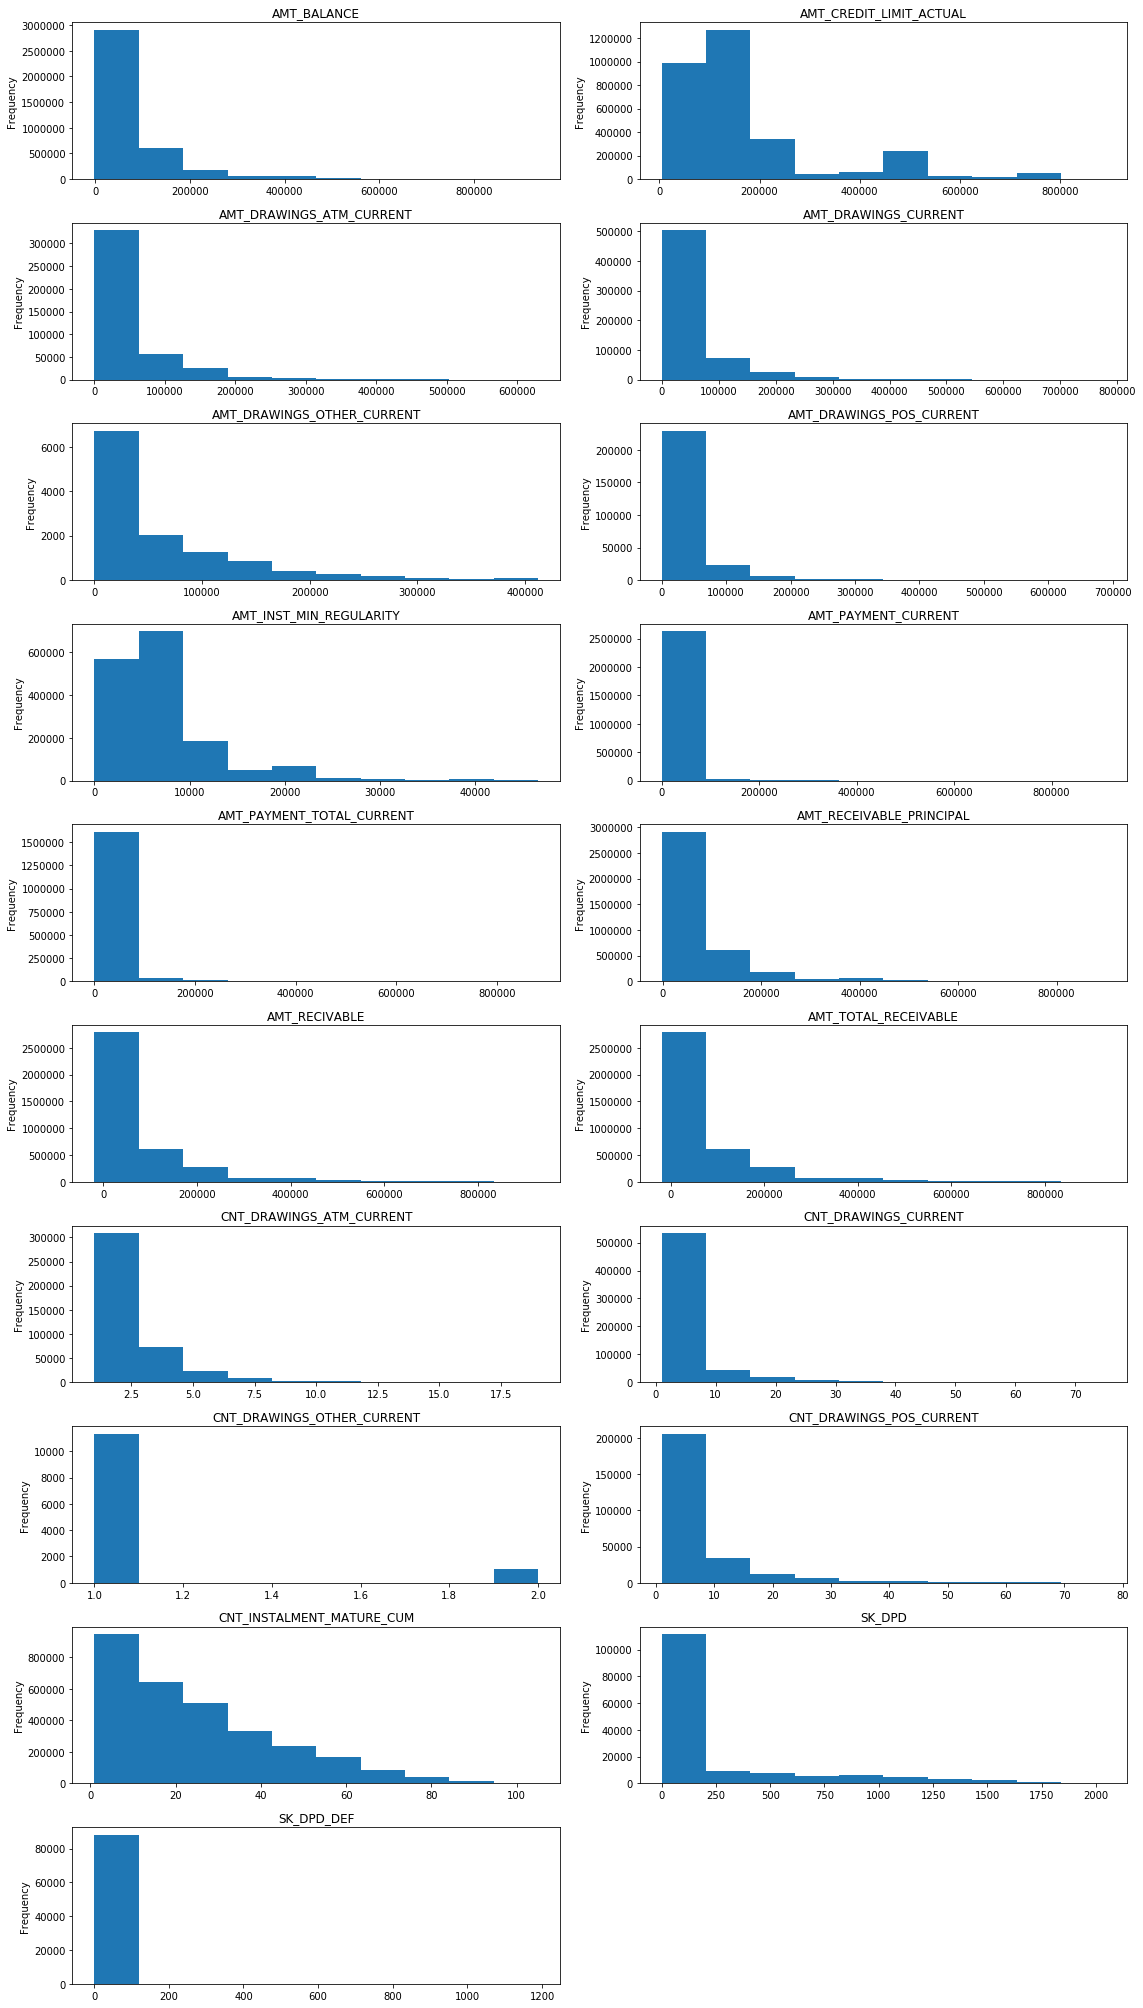

In [6]:
def draw_dist(cols):
    from math import ceil
    n_row = ceil(len(cols) / 2)
    i = 1
    plt.figure(figsize=(16, 28))
    for col in cols:
        plt.subplot(n_row, 2, i)
        if cc[col].nunique() > 10:
            up_bnd = cc[col].quantile(.9999)
            low_bnd = cc[col].quantile(.0001)
            cc[(cc[col] > low_bnd) & (cc[col] < up_bnd)][col].plot(kind='hist')
        else:
            cc[col].plot(kind='hist')
        plt.title(col)
        i += 1
    plt.tight_layout()
    plt.show()

draw_dist([col for col in cc.columns if "AMT" in col or 'CNT' in col or 'SK_DPD' in col])

In [7]:
def one_hot_encoding(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
# indicate the interest rate
cc['RECIVABLE_TO_PRINCIPAL_RATIO'] = cc['AMT_RECIVABLE'] / cc['AMT_RECEIVABLE_PRINCIPAL']
cc['RECIVABLE_SUB_PRINCIPAL'] = cc['AMT_RECIVABLE'] - cc['AMT_RECEIVABLE_PRINCIPAL']
cc['AMT_RECIVABLE_EQ_TOTAL'] = (cc['AMT_RECIVABLE'] == cc['AMT_TOTAL_RECEIVABLE']).astype('float')

cc['DRAWINGS_TO_CREDIT_RATIO'] = cc['AMT_DRAWINGS_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
cc['BALANCE_TO_CREDIT_RATIO'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
cc['PAYBACK_LT_INST_MIN'] = (cc['AMT_PAYMENT_CURRENT'] < cc['AMT_INST_MIN_REGULARITY']).astype('float')
cc['PAYBACK_TO_INST_MIN_RATIO'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']

cc['IS_DPD_GT_ZERO'] = (cc['SK_DPD'] > 0).astype('float')
cc['IS_DPD_DEF_GT_ZERO'] = (cc['SK_DPD_DEF'] > 0).astype('float')

In [9]:
# number of loans
cc_agg = cc.groupby('SK_ID_CURR')['SK_ID_PREV'].\
            nunique().\
            reset_index().\
            rename(index = str, columns = {'SK_ID_PREV': 'CC_USR_LOAN_CNT'})
cc_agg.set_index('SK_ID_CURR', inplace=True)
# number of credit balance records
cc_agg['CC_BLANCE_REC_CNT'] = cc.groupby('SK_ID_CURR').size()

# handle on payback times
temp = cc.groupby(['SK_ID_PREV', 'SK_ID_CURR'])['CNT_INSTALMENT_MATURE_CUM'].\
            max().\
            reset_index().\
            rename(index=str, columns={'CNT_INSTALMENT_MATURE_CUM': 'INSTALLMENT_TIMES_PER_LOAN'})
cc_agg['CC_PAYBACK_TIMES_TOTAL'] = temp.groupby('SK_ID_CURR')['INSTALLMENT_TIMES_PER_LOAN'].sum()
cc_agg['CC_AVG_PAYBACK_TIMES'] = cc_agg['CC_PAYBACK_TIMES_TOTAL'] / cc_agg['CC_USR_LOAN_CNT']
cc_agg['CC_PAYBACK_TO_REC_CNT_RATIO'] = cc_agg['CC_PAYBACK_TIMES_TOTAL'] / cc_agg['CC_BLANCE_REC_CNT']


num_aggregations = {
    'MONTHS_BALANCE': ['min', 'max'],
    'AMT_BALANCE': ['max', 'mean'],
    'AMT_PAYMENT_CURRENT': ['max', 'mean', 'sum'],
    'AMT_RECIVABLE': ['max', 'mean', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    # AMT_DRAWINGS
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'mean', 'sum'],

    # CNT_DRAWINGS
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_OTHER_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['max', 'mean', 'sum'],
    
    # DPD
    'SK_DPD': ['max', 'sum', 'mean'],
    'IS_DPD_GT_ZERO': ['sum', 'mean'],
    'SK_DPD_DEF': ['max', 'sum', 'mean'],
    'IS_DPD_DEF_GT_ZERO': ['sum', 'mean'],
    
    # OTHERS
    'RECIVABLE_TO_PRINCIPAL_RATIO': ['max', 'mean'],
    'RECIVABLE_SUB_PRINCIPAL': ['max', 'mean', 'min'],
    'AMT_RECIVABLE_EQ_TOTAL': ['sum', 'mean'],

    'DRAWINGS_TO_CREDIT_RATIO': ['max', 'sum', 'mean'],
    'BALANCE_TO_CREDIT_RATIO': ['max', 'sum', 'mean'],
    'PAYBACK_LT_INST_MIN': ['sum', 'mean'],
    'PAYBACK_TO_INST_MIN_RATIO': ['max', 'sum', 'mean'],
}

cc, cat_cols = one_hot_encoding(cc, nan_as_category=True)

cate_aggregations = {}
for cat in cat_cols:
    cate_aggregations[cat] = ['mean', 'sum']

cc_agg_auto = cc.groupby('SK_ID_CURR').agg({**num_aggregations, **cate_aggregations})
cc_agg_auto.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg_auto.columns.tolist()])

# SOME ADDITIONAL OPERATION
cc_agg_auto['CC_DRAWINGS_AMT_ATM_RATIO'] = cc_agg_auto['CC_AMT_DRAWINGS_ATM_CURRENT_SUM'] / cc_agg_auto['CC_AMT_DRAWINGS_CURRENT_SUM']
cc_agg_auto['CC_DRAWINGS_AMT_OTHER_RATIO'] = cc_agg_auto['CC_AMT_DRAWINGS_OTHER_CURRENT_SUM'] / cc_agg_auto['CC_AMT_DRAWINGS_CURRENT_SUM']
cc_agg_auto['CC_DRAWINGS_AMT_POS_RATIO'] = cc_agg_auto['CC_AMT_DRAWINGS_POS_CURRENT_SUM'] / cc_agg_auto['CC_AMT_DRAWINGS_CURRENT_SUM']

cc_agg_auto['CC_DRAWINGS_CNT_ATM_RATIO'] = cc_agg_auto['CC_CNT_DRAWINGS_ATM_CURRENT_SUM'] / cc_agg_auto['CC_CNT_DRAWINGS_CURRENT_SUM']
cc_agg_auto['CC_DRAWINGS_CNT_OTHER_RATIO'] = cc_agg_auto['CC_CNT_DRAWINGS_OTHER_CURRENT_SUM'] / cc_agg_auto['CC_CNT_DRAWINGS_CURRENT_SUM']
cc_agg_auto['CC_DRAWINGS_CNT_POS_RATIO'] = cc_agg_auto['CC_CNT_DRAWINGS_POS_CURRENT_SUM'] / cc_agg_auto['CC_CNT_DRAWINGS_CURRENT_SUM']

cc_agg_auto['CC_AVG_DRAWINGS'] = cc_agg_auto['CC_AMT_DRAWINGS_ATM_CURRENT_SUM'] / cc_agg_auto['CC_CNT_DRAWINGS_CURRENT_SUM']
cc_agg = cc_agg.join(cc_agg_auto)
del cc, temp, cc_agg_auto
gc.collect()

51021

In [10]:
for col in cc_agg.columns:
    print(col)

CC_USR_LOAN_CNT
CC_BLANCE_REC_CNT
CC_PAYBACK_TIMES_TOTAL
CC_AVG_PAYBACK_TIMES
CC_PAYBACK_TO_REC_CNT_RATIO
CC_MONTHS_BALANCE_MIN
CC_MONTHS_BALANCE_MAX
CC_AMT_BALANCE_MAX
CC_AMT_BALANCE_MEAN
CC_AMT_PAYMENT_CURRENT_MAX
CC_AMT_PAYMENT_CURRENT_MEAN
CC_AMT_PAYMENT_CURRENT_SUM
CC_AMT_RECIVABLE_MAX
CC_AMT_RECIVABLE_MEAN
CC_AMT_RECIVABLE_SUM
CC_AMT_INST_MIN_REGULARITY_MAX
CC_AMT_INST_MIN_REGULARITY_MEAN
CC_AMT_DRAWINGS_ATM_CURRENT_MAX
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN
CC_AMT_DRAWINGS_ATM_CURRENT_SUM
CC_AMT_DRAWINGS_CURRENT_MAX
CC_AMT_DRAWINGS_CURRENT_MEAN
CC_AMT_DRAWINGS_CURRENT_SUM
CC_AMT_DRAWINGS_OTHER_CURRENT_MAX
CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN
CC_AMT_DRAWINGS_OTHER_CURRENT_SUM
CC_AMT_DRAWINGS_POS_CURRENT_MAX
CC_AMT_DRAWINGS_POS_CURRENT_MEAN
CC_AMT_DRAWINGS_POS_CURRENT_SUM
CC_CNT_DRAWINGS_ATM_CURRENT_MAX
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
CC_CNT_DRAWINGS_ATM_CURRENT_SUM
CC_CNT_DRAWINGS_CURRENT_MAX
CC_CNT_DRAWINGS_CURRENT_MEAN
CC_CNT_DRAWINGS_CURRENT_SUM
CC_CNT_DRAWINGS_OTHER_CURRENT_MAX
CC_C

In [11]:
len(cc_agg.columns)

92